# Method descriptions

* **global-reg** learn local clfs and a global one
* **lafond** 
* **regularised** learns local classifiers with laplacian constraint
* **local** learns independent local classifiers


In [1]:
# imports
from copy import deepcopy
import numpy as np

from sklearn.utils import shuffle

import sys
sys.path.append('../src/')

from classification import get_stumps
from evaluation import central_accuracy
from network import synthetic_graph
from related_works import colearning, lafond_FW
from optimization import regularized_local_FW, local_FW, global_regularized_local_FW, gd_reg_local_FW, centralized_FW
from utils import generate_models, generate_moons, get_min_max

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# set graph of nodes with local personalized data
NB_ITER = 1000
N = 20
D = 20
B = 200
NOISE_R = 0.05
random_state = 2017
MU = 0.01
BETA = 10

V, theta_true, cluster_indexes = generate_models(nb_clust=1, nodes_per_clust=N, random_state=random_state)
_, X, Y, X_test, Y_test, _, _ = generate_moons(V, theta_true, D, random_state=random_state, sample_error_rate=NOISE_R)

# set graph
nodes, adj_matrix, similarities = synthetic_graph(X, Y, X_test, Y_test, V, theta_true)

# set callbacks for optimization analysis
callbacks = {
    'accuracy': [central_accuracy, []]
}

# get weak classifiers
vmin, vmax = get_min_max(X)
base_clfs = get_stumps(n=B, d=D+1, min_v=vmin, max_v=vmax)

In [6]:
results = {}

# nodes_copy = deepcopy(nodes)
# results["centralized"] = centralized_FW(nodes_copy, base_clfs, beta=BETA, nb_iter=NB_ITER, callbacks=callbacks)

nodes_regularized = deepcopy(nodes)
results["regularized"] = regularized_local_FW(nodes_regularized, base_clfs, beta=BETA, nb_iter=NB_ITER, mu=MU, callbacks=callbacks)

nodes_copy = deepcopy(nodes)
results["lafond"] = lafond_FW(nodes_copy, base_clfs, beta=BETA, nb_iter=NB_ITER, callbacks=callbacks)

local_nodes = deepcopy(nodes)
results["local"] = local_FW(local_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, callbacks=callbacks)

nodes_copy = deepcopy(nodes)
results["global-reg"] = global_regularized_local_FW(nodes_copy, base_clfs, beta=BETA, nb_iter=NB_ITER, callbacks=callbacks)

# colearning results
results["colearning"], clf_colearning = colearning(N, X, Y, X_test, Y_test, D, NB_ITER, adj_matrix, similarities)

gd_nodes = deepcopy(nodes)
results["gd-regularized"] = gd_reg_local_FW(gd_nodes, base_clfs, pace_gd=10, beta=BETA, nb_iter=NB_ITER, callbacks=callbacks)
print("done")

done


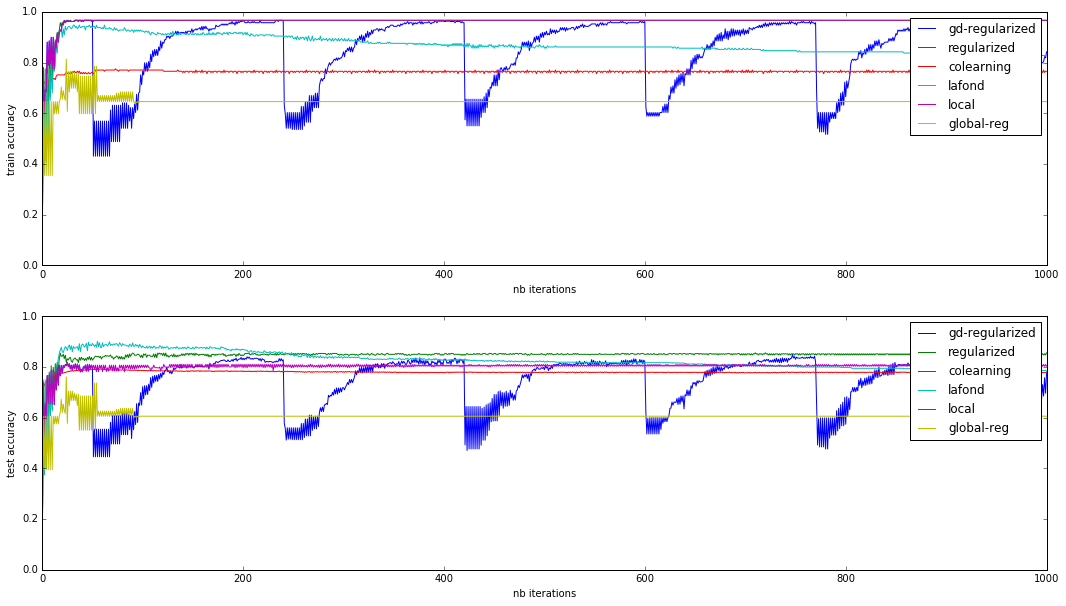

In [7]:
plt.figure(1, figsize=(18, 10))

plt.subplot(211)
plt.xlabel('nb iterations')
plt.ylabel('train accuracy')

for k, r_list in results.items():
    plt.plot(range(len(r_list)), [r['accuracy'][0] for r in r_list], label='{}'.format(k))

plt.legend()

plt.subplot(212)
plt.xlabel('nb iterations')
plt.ylabel('test accuracy')

for k, r_list in results.items():
    plt.plot(range(len(r_list)), [r['accuracy'][1] for r in r_list], label='{}'.format(k))

plt.legend()

In [14]:
for r in results["gd-regularized"]:
    
    try:
        print('adj-matrix', r['adj-matrix'])
        print('diff', r['adj-matrix']/np.linalg.norm(r['adj-matrix']) - similarities/np.linalg.norm(similarities))
    except Exception as e:
        pass

adj-matrix [[  0.00000000e+00   7.68214175e-14   5.03452640e-14 ...,   0.00000000e+00
    0.00000000e+00   2.59348450e-14]
 [  2.78047669e-14   0.00000000e+00   1.15680396e-13 ...,   0.00000000e+00
    2.05025028e-14   3.82819136e-14]
 [  0.00000000e+00   8.42126018e-14   0.00000000e+00 ...,   1.40247527e-13
    1.34088273e-13   8.27378215e-14]
 ..., 
 [  0.00000000e+00   0.00000000e+00   1.62605401e-13 ...,   7.67378807e-14
    5.00019009e-13   2.16223183e-13]
 [  0.00000000e+00   6.78372536e-14   3.42419509e-13 ...,   6.27806481e-12
    2.67930288e-14   2.41726011e-13]
 [  0.00000000e+00   2.53631770e-14   9.40328017e-14 ...,   2.07588531e-13
    1.08888191e-13   0.00000000e+00]]
diff 30.8625633965
adj-matrix [[  0.00000000e+00   1.45454611e-13   1.12824121e-13 ...,   6.75230945e-14
    0.00000000e+00   1.05757370e-13]
 [  1.73915383e-13   4.98847759e-15   4.08981879e-13 ...,   3.21696334e-13
    6.23785568e-13   2.23756980e-13]
 [  0.00000000e+00   2.38948688e-14   0.00000000e+00 ..